In [1]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

#### Параметры моделирования

In [2]:
# Время симуляции жизни улицы, в минутах
SIM_TIME = 30 * 24 * 60

# Параметры нормального распределения для входа посетителя, среднее и дисперсия
PERSON_IN_MEAN = 5
PERSON_IN_DISP = 2

# Кортеж параметров заведений
# (id, 'Название', вероятность входа, кол-во касс, время обслуж.: среднее, дисперсия)
PLACES = (
    (0, 'Shop_1', 0.3, 3, 5, 2),
    (1, 'Shop_2', 0.3, 3, 5, 2),
    (2, 'Pharmacy', 0.1, 2, 5, 2),
    (3, 'Kiosk', 0.1, 1, 3, 2),
    (4, 'Barbershop', 0.1, 2, 20, 2)
)

# Параметры для итоговой визуализации для удобства перенесены перед самой визуализацией

In [3]:
# Возвращает целое число больше нуля из нормального распеделения mean, disp
def randint_norm(mean, disp):
    res = np.int(np.around(np.random.normal(mean, np.sqrt(disp))))
    return res if res > 0 else 0


# Основной класс моделирования - Улица                     
class Street:
                     
    def __init__(self, env):
        self.env = env        # simpy.Environment()
        # Массив для хранения всех происходящих событий
        # [id_person, id_place, 'action_type', time]
        self.actions = []        
        self.places = {plc[0]: Place(plc, self.env) for plc in PLACES}
        self.env.process(self.input_person())
        
    # Появление посетителя на улице
    def input_person(self):
        id_person = 0
        while True:
            # Ждем появления, создаем объект класса и записываем событие
            yield self.env.timeout(randint_norm(PERSON_IN_MEAN, PERSON_IN_DISP))
            Person(id_person, self)
            # -1 это id_place для события входа и выхода с улицы
            self.actions.append([id_person, -1, 'in', self.env.now])
            id_person += 1

    
class Place:
    
    def __init__(self, params, env):
        # params = (id_, name, prob_in, cashbox_num, cb_mean, cb_disp)
        self.id_, self.name, self.prob_in = params[:3]
        self.cb_num, self.cb_mean, self.cb_disp = params[3:]
        
        self.env = env
        # Использовал для работы с кассами заведений simpy.Resource
        # Знаю, что излишне, когда посетитель не ждет очередь, а сразу уходит
        # но было интересно через simpy концепт сделать
        self.cashboxes = simpy.Resource(self.env, capacity=params[3])
             
    # Проверка наличия свободной кассы
    def is_free(self):
        if self.cashboxes.count < self.cb_num:
            return True
        else:
            return False
    
    
class Person:
    
    def __init__(self, id_, _street):
        self.id_ = id_
        self.places_visited = {i:False for i in _street.places.keys()}
        _street.env.process(self.next_place(_street))
        
    # Реализация посещения заведений
    def next_place(self, _street):
        on_street = True
        while on_street:
            
            # Случайный выбор заведения для посещения согласно распределению вероятностей
            # -1 это id_place для события выхода (и входа) с улицы
            place_id_to_go = -1
            # Выбор делаем с помощью случайного числа от 0 до 1 и накопительной суммы,
            # так как сумма вероятностей посещения всех заведений = 1
            prob_to_go = np.random.random()
            prob_sum = 0.          
            for _place in _street.places.values():
                prob_sum += _place.prob_in
                if prob_to_go < prob_sum:
                    place_id_to_go = _place.id_
                    break
                    
            # Выходим с улицы, если выпал выход с улицы или мы уже были
            # в выпавшем заведении 
            if place_id_to_go == -1 or self.places_visited[place_id_to_go]:
                on_street = False
                _street.actions.append([self.id_, -1, 'out', _street.env.now])
                
            else:              
                self.places_visited[place_id_to_go] = True                
                # Если в заведении есть свободная касса, то занимаем её и ждём время обслуживания
                # записывая время входа и выхода
                if _street.places[place_id_to_go].is_free():
                    with _street.places[place_id_to_go].cashboxes.request() as req:
                        yield req
                        
                        _street.actions.append([self.id_, place_id_to_go, 'in', _street.env.now])                        
                        yield _street.env.timeout(randint_norm(_street.places[place_id_to_go].cb_mean,
                                                               _street.places[place_id_to_go].cb_disp))
                        _street.actions.append([self.id_, place_id_to_go, 'out', _street.env.now])
                        
                # Если нет свободных касс, то сразу уходим, записав 'in_out' событие 
                else:
                    _street.actions.append([self.id_, place_id_to_go, 'in_out', _street.env.now])


In [4]:
# Запускаем моделирование с временем SIM_TIME
np.random.seed(55)
env = simpy.Environment()
street = Street(env)
env.run(until=SIM_TIME)

# Преобразуем в pandas формат журнал событий и смотрим, что получилось
df_actions = pd.DataFrame(data=street.actions, columns=['id_person', 'id_place','action', 'time'])
print(df_actions.info())
print('')
print('All actions table')
df_actions.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49103 entries, 0 to 49102
Data columns (total 4 columns):
id_person    49103 non-null int64
id_place     49103 non-null int64
action       49103 non-null object
time         49103 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None

All actions table


,id_person,id_place,action,time
0,0,-1,in,3
1,0,1,in,3
2,1,-1,in,8
3,1,0,in,8
4,0,1,out,9
5,0,0,in,9
6,2,-1,in,12
7,2,4,in,12
8,1,0,out,13
9,1,-1,out,13


In [5]:
# Фильтруем события, которые нам интересны для исследования:
# убираем вход и выход с улицы и события 'in_out' (когда все кассы были заняты) 
df = df_actions[(df_actions.id_place != -1) & (df_actions.action.isin(['in', 'out']))]

# Смотрим распределение записей для уникальных пар посетитель-заведение
# Для большинства пар количество записей должно быть 2 (вход и выход),
# 1 запись это для тех кто вошел в заведение и не успел выйти до конца симуляции
df.groupby(['id_person', 'id_place']).size().to_frame('count_records_in_table')\
            .groupby('count_records_in_table').size().to_frame('quantity')

,quantity
count_records_in_table,
1,2
2,15613


In [6]:
# Теперь составляем таблицу посещений, совмещая записи для входа и выхода
df_res = pd.merge(df[df.action=='in'], df[df.action=='out'], how='inner', 
                  on=['id_person', 'id_place'], suffixes=('_in', '_out'),
                  sort=True).drop(columns=['action_in', 'action_out'])

# Выгружаем в csv, !меняя местами колонки!
df_res[['id_place','id_person', 'time_in', 'time_out']].sort_values(by=['time_in']).\
        to_csv('result.csv', index=False)

# Смотрим, что получилось
print(df_res.info())
df_res.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15613 entries, 0 to 15612
Data columns (total 4 columns):
id_person    15613 non-null int64
id_place     15613 non-null int64
time_in      15613 non-null int64
time_out     15613 non-null int64
dtypes: int64(4)
memory usage: 609.9 KB
None


,id_person,id_place,time_in,time_out
0,0,0,9,13
1,0,1,3,9
2,1,0,8,13
3,2,0,33,37
4,2,4,12,33
5,3,0,30,33
6,3,1,19,23
7,3,2,23,30
8,4,1,29,35
9,4,3,25,29


#### Парметры для визуализации

##### В задании задано время за час до и после, но как можно прикинуть из условия, час почти никто не проведет на улице с такими параметрами (распределение по времени нахождения на улице людей имеет параметры mean~12, std~10, посчитал из  смоделированных данных). Поэтому по умолчанию поставил 10 минут

In [7]:
# id заведения для которого строим отчет
# 0 - 'Shop_1'| 1 - 'Shop_2'| 2 - 'Pharmacy' | 3 - 'Kiosk | 4 - 'Barbershop'
ID_MAIN_PLACE = 2

# Отклонение по времени в минутах по котрому строим итоговый отчет посещаемости.
DIF_TIME = 10

Так как, например, в аптеке посетитель проводит какое-то время, то за DIF_TIME минут **до прихода** в аптеку он мог быть в парикхмахерской, а за DIF_TIME **до ухода** из аптеки в киоске. Значит есть 2 варианта построения отчета:
* Если мы больше хотим получить полноту данных, то берем промежуток времени, в который посетитель был в целевом заведении, переносим его на DIF_TIME минут назад и вперед и берем все заведения, которые попали в эти промежутки. Далее **вариант полноты (fullness version)**
* Если нам важно взаимооднозначное соответствие для одного посетителя между местом, по которому мы строим отчет, и предыдущим местом (сохранить 'пропорциональность' данных), то возьмем одно время (например посередине между входом и выходом) и для него смотрим в каком месте был за DIF_TIME до и после этого времени. Далее **вариант однозначности (one-to-one version)**

#### Рассчитываем вариант полноты

In [8]:
# Делаем outer слияние таблицы самой с собой по id_person
df_full = pd.merge(df_res, df_res, how='outer', on='id_person', suffixes=('_main', '_other'))

# Теперь фильтруем записи по условиям посещения за DIF_TIME до и после main заведения
df_full_before = df_full[(df_full.id_place_main != df_full.id_place_other)
                 & (df_full.time_out_main - DIF_TIME >= df_full.time_in_other)
                 & (df_full.time_in_main - DIF_TIME <= df_full.time_out_other)]

df_full_after = df_full[(df_full.id_place_main != df_full.id_place_other)
                 & (df_full.time_out_main + DIF_TIME >= df_full.time_in_other)
                 & (df_full.time_in_main + DIF_TIME <= df_full.time_out_other)]

# И собираем в сводную таблицу для случая до и после main заведения
pivot_full_before = df_full_before.pivot_table(index='id_place_main', columns='id_place_other',
                                               values='id_person', aggfunc='count')
pivot_full_after = df_full_after.pivot_table(index='id_place_main', columns='id_place_other',
                                             values='id_person', aggfunc='count')

print('Fullness variant')
print('-------------------------------------------------')
print(f'Amount of people {DIF_TIME} minutes before main place')
print(pivot_full_before)
print('-------------------------------------------------')
print(f'Amount of people {DIF_TIME} minutes after main place')
print(pivot_full_after)

Fullness variant
-------------------------------------------------
Amount of people 10 minutes before main place
id_place_other      0      1      2      3      4
id_place_main                                    
0                 NaN  839.0  441.0  196.0  549.0
1               866.0    NaN  420.0  211.0  502.0
2               412.0  421.0    NaN  112.0  250.0
3               191.0  199.0   98.0    NaN  243.0
4               534.0  558.0  220.0  223.0    NaN
-------------------------------------------------
Amount of people 10 minutes after main place
id_place_other      0      1      2      3      4
id_place_main                                    
0                 NaN  866.0  412.0  191.0  534.0
1               839.0    NaN  421.0  199.0  558.0
2               441.0  420.0    NaN   98.0  220.0
3               196.0  211.0  112.0    NaN  223.0
4               549.0  502.0  250.0  243.0    NaN


In [9]:
# Делаем outer слияние таблицы самой с собой по id_person
df_one = pd.merge(df_res, df_res, how='outer', on='id_person', suffixes=('_main', '_other'))

# Теперь фильтруем записи по условиям посещения за DIF_TIME до и после main заведения
df_one_before = df_one[(df_one.id_place_main != df_one.id_place_other)
                 & (df_one[['time_in_main','time_out_main']].mean(axis=1) - DIF_TIME >= df_one.time_in_other)
                 & (df_one[['time_in_main','time_out_main']].mean(axis=1) - DIF_TIME < df_one.time_out_other)]

df_one_after = df_one[(df_one.id_place_main != df_one.id_place_other)
                 & (df_one[['time_in_main','time_out_main']].mean(axis=1) + DIF_TIME > df_one.time_in_other)
                 & (df_one[['time_in_main','time_out_main']].mean(axis=1) + DIF_TIME <= df_one.time_out_other)]

# И собираем в сводную таблицу для случая до и после main заведения
pivot_one_before = df_one_before.pivot_table(index='id_place_main', columns='id_place_other',
                                             values='id_person', aggfunc='count')
pivot_one_after = df_one_after.pivot_table(index='id_place_main', columns='id_place_other',
                                           values='id_person', aggfunc='count')

print('One-to-one variant')
print('-------------------------------------------------')
print(f'Amount of people {DIF_TIME} minutes before main place')
print(pivot_one_before)
print('-------------------------------------------------')
print(f'Amount of people {DIF_TIME} minutes after main place')
print(pivot_one_after)
print('-------------------------------------------------')

One-to-one variant
-------------------------------------------------
Amount of people 10 minutes before main place
id_place_other      0      1      2     3      4
id_place_main                                   
0                 NaN  244.0  141.0  61.0  524.0
1               233.0    NaN  131.0  78.0  471.0
2               164.0  136.0    NaN  40.0  230.0
3                78.0  104.0   56.0   NaN  235.0
4               137.0  150.0   50.0  40.0    NaN
-------------------------------------------------
Amount of people 10 minutes after main place
id_place_other      0      1      2     3      4
id_place_main                                   
0                 NaN  230.0  149.0  51.0  509.0
1               240.0    NaN  140.0  65.0  532.0
2               159.0  136.0    NaN  35.0  202.0
3               100.0  112.0   56.0   NaN  215.0
4               155.0  121.0   57.0  49.0    NaN
-------------------------------------------------


##### Как видим цифры в 2ух вариантах различаются в несколько раз, а также не везде сохраняется пропорциональность (особенно когда попадает самое большое по времени посещения завидение - Парикмахерская, id=4)

In [10]:
# Функция отрисовки количества посетителей
# Думаю комментировать тут не нужно
# Слишком много всяких мелочей
def draw_barchart_for_one_place(pivot_tables, place_id, dtime):   
    fig = plt.figure(figsize=(12, 11))
    clrs_set = ['khaki', 'aqua', 'lightcoral', 'lightgreen', 'orchid']
    
    ax_num = 221
    for pivot_before, pivot_after, version in pivot_tables:
        ax1 = fig.add_subplot(ax_num)
        ax_num += 1
        ax2 = fig.add_subplot(ax_num)
        ax_num += 1
        
        #Draw before barchart
        data_before = pivot_before.loc[place_id].dropna().astype('int64').sort_values(ascending=False).to_dict()
        items_before = data_before.items()

        names_before = [street.places[i[0]].name for i in items_before]
        clrs = [clrs_set[i[0]] for i in items_before]
        count_before = [-i[1] for i in items_before]
        pos_before = [i for i in range(len(items_before))]

        rects = ax1.barh(pos_before, count_before, align='center', alpha=0.8,
                         tick_label=[''*len(items_before)], color = clrs)
        ax1.set_title(f'{dtime} minutes before [{version} version]')
        ax1.set_xlabel('Number of persons')

        num = 0
        for rect in rects:
            width = int(rect.get_width())

            if width < ax1.get_xlim()[0] / 2.2:
                xloc = 5
                clr = 'k'
                align = 'left'
            else:
                xloc = -5
                clr = 'k'
                align = 'right'

            yloc = rect.get_y() + rect.get_height() / 2
            label = ax1.annotate(f'{names_before[num]} ({abs(width)})', xy=(width, yloc), xytext=(xloc, 0),
                                textcoords="offset points",
                                ha=align, va='center',
                                color=clr, weight='bold', clip_on=True)
            num += 1

        #Draw ater barchrat
        data_after = pivot_after.loc[place_id].dropna().astype('int64').sort_values(ascending=False).to_dict()
        items_after = data_after.items()

        names_after = [street.places[i[0]].name for i in items_after]
        count_after = [i[1] for i in items_after]
        pos_after = [i for i in range(len(items_after))]

        rects = ax2.barh(pos_after, count_after, align='center', alpha=0.8,
                         tick_label=[''*len(items_before)], color = clrs)
        ax2.set_title(f'{dtime} minutes after [{version} version]')
        ax2.set_xlabel('Number of persons')

        num = 0
        for rect in rects:
            width = int(rect.get_width())

            if width < ax2.get_xlim()[1] / 2.2:
                xloc = 5
                clr = 'k'
                align = 'left'
            else:
                xloc = -5
                clr = 'k'
                align = 'right'

            yloc = rect.get_y() + rect.get_height() / 2
            label = ax2.annotate(f'{names_after[num]} ({abs(width)})', xy=(width, yloc), xytext=(xloc, 0),
                                 textcoords="offset points", ha=align, va='center', color=clr,
                                 weight='bold', clip_on=True)
            num += 1

    fig.suptitle(f'Number of people who visited {street.places[place_id].name}', fontsize= 15)
    plt.subplots_adjust(wspace=0, hspace=0.4)
    plt.show()

##### Вызываем итоговую визуализацию для заданной компании ID_MAIN_PLACE с количеством посетителей за DIF_TIME до и после посещения ID_MAIN_PLACE

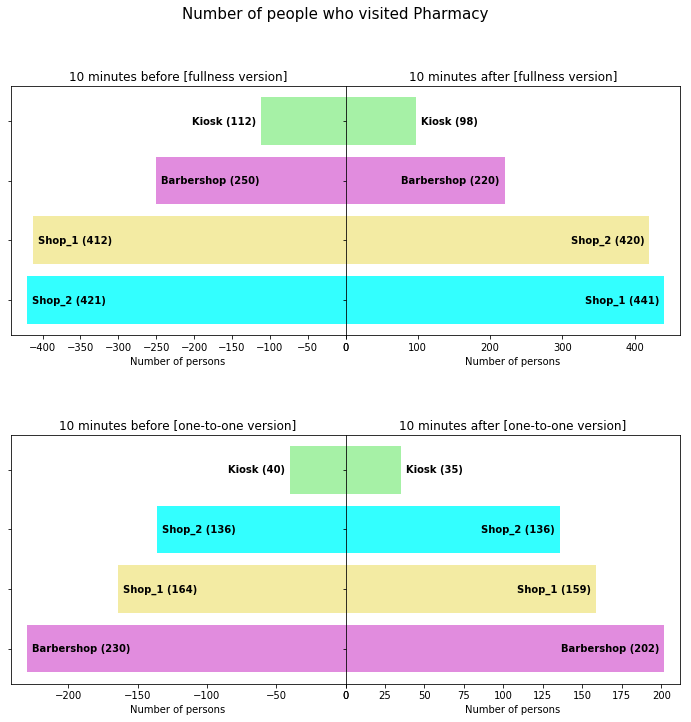

In [11]:
draw_barchart_for_one_place([[pivot_full_before, pivot_full_after, 'fullness'],
                            [pivot_one_before, pivot_one_after, 'one-to-one']],
                            ID_MAIN_PLACE, DIF_TIME)